<h2>Introduction</h2>

Anomaly detection, where we seek to identify events or datasets that deviate from those normally encountered, is a common task in experimental particle physics. For example, two runs recorded on the same day with identical accelerator and detector conditions and the same trigger menu should not be distinguishable statistically. If they are, some unexpected systematic effect must be present which acts to skew each event or a subset of the events, leading to a collective anomaly. There are many ways in which such problems can arise: for instance, the data acquisition or reconstruction software might be misconfigured, or some subcomponent of the detector might be malfunctioning.    
 
Conversely, an otherwise normal dataset may contain individual events which are somehow unusual. These point anomalies may arise due to a problem with the detector, data acquisition, trigger or reconstruction that only occur in very rare circumstances. 

For both cases it would be highly desirable to devise a mechanism that could automatically scan all new datasets, detect any anomalous features, and alert a human being to enable detailed investigation. This is the subject of today's RAMP. 



<h3>The prediction task</h3>

The nature of the challenge is to devise a classifier that can distinguish the anomalous cases from the bulk of the data in a test dataset, having first trained the classifier on a test dataset. Whilst the anomalous events are labelled in the training set, no distinction is made between the different types of distortion.

<b>The challenge in this RAMP is to Separate a skewed data point from a original data point</b>

<h2>Data</h2>

A version of the <a href="http://opendata.cern.ch/collection/ATLAS-Higgs-Challenge-2014?ln=en">HiggsML dataset</a> (used in the <a href="https://higgsml.lal.in2p3.fr/">Kaggle Challenge</a> in 2014) is provided. It contains a mixture of Higgs particles decaying into tau pairs and the principal background processes. One half of the data is unchanged but the other half has been artificially distorted in various ways (details will be given in the course of the RAMP).

The full dataset contains approximately 800K events.
We are giving you 100k events to build models and will use the rest to test them.

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0  
* pandas>=0.17.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)  

In [1]:
from __future__ import division, print_function
import os
import sys
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try :
    import seaborn as sns; sns.set()
except ImportError:
    print("seaborn not found on your computer. "
          "Install it if you want pretty charts \n"
          "If you have internet access you can run in a cell : \n"
          "!pip install -U seaborn ")

pd.set_option('display.max_columns', None)

In [2]:
%matplotlib inline

## Exploratory data analysis

### Loading the data

In [3]:
data = pd.read_csv('public_train.csv.gz', compression='gzip')
X_df = data.drop(['isSkewed'], axis=1)
Y_df = Y_df = data[['isSkewed']]

In [4]:
data.head()

,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,isSkewed
0,1.937,64.546,41.791,2.301,7.975,105.305,0.926,1.087,36.259,-2.248,-2.239,33.582,-1.893,0.035,19.872,-0.040,0
1,69.892,61.447,157.875,1.618,2.756,238.670,1.239,1.311,36.622,1.748,1.720,45.385,1.078,-3.090,100.619,2.807,1
2,4.252,73.423,56.958,3.018,77.300,266.566,0.823,-0.622,40.520,1.337,0.564,33.370,1.373,-2.701,64.063,-2.609,0
3,76.695,60.761,1.770,2.077,1.770,70.690,1.578,-1.381,27.419,-0.512,0.345,43.271,-0.025,2.365,38.189,-1.453,1
4,21.288,60.049,13.166,2.966,71.566,265.146,0.826,1.393,32.143,1.651,-0.056,26.566,2.164,2.866,4.801,0.406,1


## Feature description

See more details in http://opendata.cern.ch/record/329 page 16.


- **DER_mass_transverse_met_lep:** The transverse mass between the missing transverse energy and the lepton.

- **DER_mass_vis:** The invariant mass of the hadronic tau and the lepton.

- **DER_pt_h:** The modulus of the vector sum of the transverse momentum of the hadronic tau, the lepton, and the missing transverse energy vector.


- **DER_deltar_tau_lep:** The R separation between the hadronic tau and the lepton.

- **DER_pt_tot:** The modulus of the vector sum of the missing transverse momenta and the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI_jet_num $\geq$) and the subleading jet (if PRI jet num = 2) (but not of any additional jets).

- **DER_sum_pt:** The sum of the moduli of the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI jet num $\geq$ 1) and the subleading jet (if PRI jet num = 2) and the other jets (if PRI jet num = 3).

- **DER_pt_ratio_lep_tau:** The ratio of the transverse momenta of the lepton and the hadronic tau.

- **DER_met_phi_centrality:** The centrality of the azimuthal angle of the missing transverse energy vector w.r.t. the hadronic tau and the lepton.

- **PRI_tau_pt:** The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the hadronic tau.

- **PRI_tau_eta:** The pseudorapidity $\eta$ of the hadronic tau.

- **PRI_tau_phi:** The azimuth angle $\phi$ of the hadronic tau.

- **PRI_lep_pt:** The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the lepton (electron or muon).

- **PRI_lep_eta:** The pseudorapidity $\eta$ of the lepton.

- **PRI_lep_phi:** The azimuth angle $\phi$ of the lepton.

- **PRI_met:** The missing transverse energy $\overrightarrow{E}^{miss}_{T}$

- **PRI_met_phi:** The azimuth angle $\phi$ of the mssing transverse energy

- **isSkewed:** The event origin, 0: original distribution ; 1: skewed distribution .



Check for missing values

In [5]:
(X_df == -999.).any()

DER_mass_transverse_met_lep    False
DER_mass_vis                   False
DER_pt_h                       False
DER_deltar_tau_lep             False
DER_pt_tot                     False
DER_sum_pt                     False
DER_pt_ratio_lep_tau           False
DER_met_phi_centrality         False
PRI_tau_pt                     False
PRI_tau_eta                    False
PRI_tau_phi                    False
PRI_lep_pt                     False
PRI_lep_eta                    False
PRI_lep_phi                    False
PRI_met                        False
PRI_met_phi                    False
dtype: bool

In [6]:
Y_df.head()

,isSkewed
0,0
1,1
2,0
3,1
4,1


In [7]:
X_df.head()

,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi
0,1.937,64.546,41.791,2.301,7.975,105.305,0.926,1.087,36.259,-2.248,-2.239,33.582,-1.893,0.035,19.872,-0.040
1,69.892,61.447,157.875,1.618,2.756,238.670,1.239,1.311,36.622,1.748,1.720,45.385,1.078,-3.090,100.619,2.807
2,4.252,73.423,56.958,3.018,77.300,266.566,0.823,-0.622,40.520,1.337,0.564,33.370,1.373,-2.701,64.063,-2.609
3,76.695,60.761,1.770,2.077,1.770,70.690,1.578,-1.381,27.419,-0.512,0.345,43.271,-0.025,2.365,38.189,-1.453
4,21.288,60.049,13.166,2.966,71.566,265.146,0.826,1.393,32.143,1.651,-0.056,26.566,2.164,2.866,4.801,0.406


In [8]:
X_df.describe()

,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,52.618045,89.843398,69.149389,2.402999,30.190263,169.935810,1.708225,-0.130873,39.717522,0.056565,-0.002615,57.103112,-0.022483,0.044010,42.841581,-0.010388
std,43.007245,61.979805,95.653894,0.815938,73.043256,138.721865,2.419824,1.194250,23.316137,1.277961,1.816882,76.709654,1.267831,1.817974,33.370627,1.812210
min,0.000000,7.334000,0.001000,0.228000,0.001000,46.286000,0.045000,-1.414000,20.000000,-2.496000,-3.142000,26.000000,-2.494000,-3.142000,0.158000,-3.141000
25%,20.027000,60.711000,16.690000,1.824000,3.419000,79.044000,0.872000,-1.371000,25.198000,-0.903000,-1.576000,32.540000,-1.018000,-1.518250,21.760000,-1.574000
50%,47.998000,75.786500,41.547000,2.507000,16.009500,124.444000,1.269000,-0.366000,32.537000,0.024000,-0.014000,40.983000,-0.051000,0.081000,35.426000,-0.015000
75%,75.571250,96.855250,86.094750,2.979000,29.946000,211.277000,1.788000,1.227000,46.037500,0.983000,1.577000,54.724250,0.958000,1.619000,53.529250,1.564000
max,1318.682000,2145.712000,3157.497000,6.025000,2656.503000,3563.050000,99.890000,1.414000,654.005000,2.800000,3.142000,2985.960000,2.497000,3.141000,951.363000,3.142000


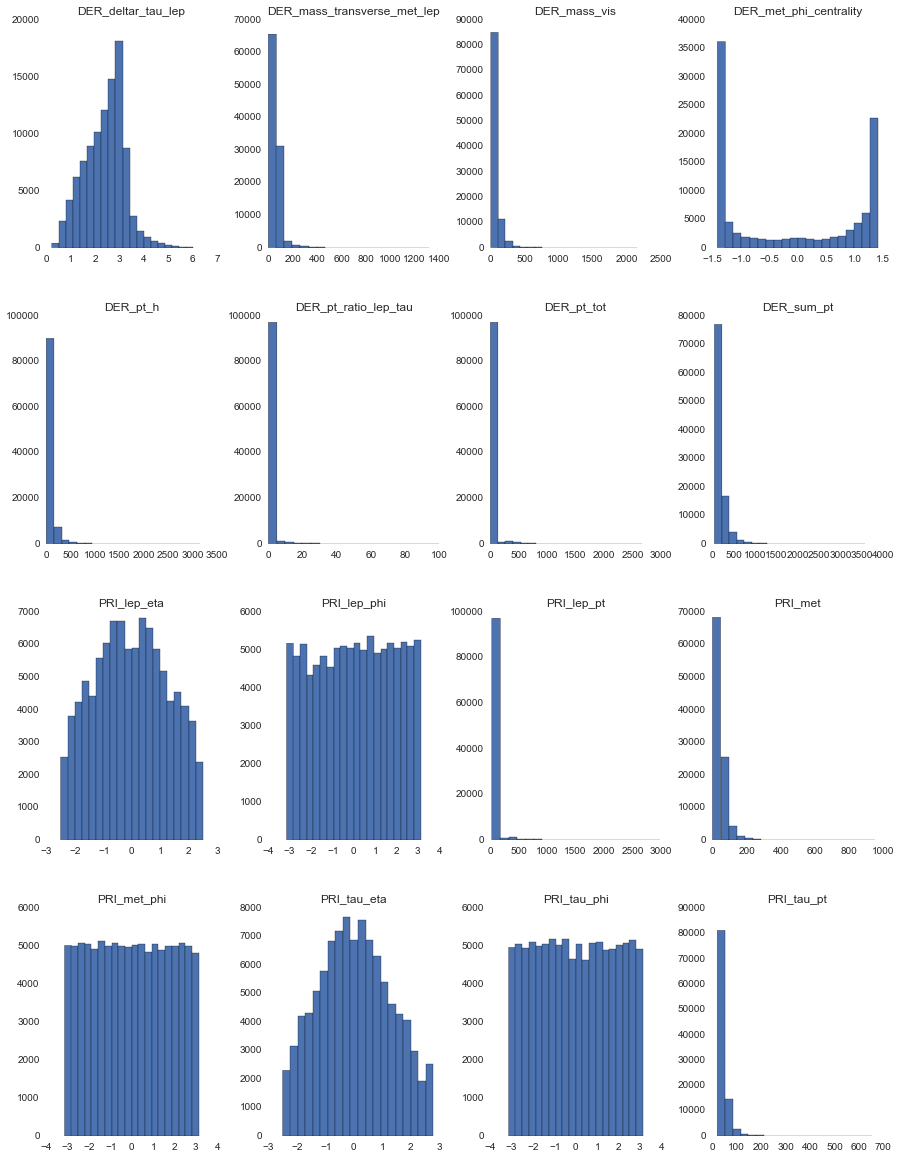

In [9]:
X_df.hist(figsize=(15, 20), bins=20);

Look at the distribution difference between the *original* and *skewed* data on each feature.

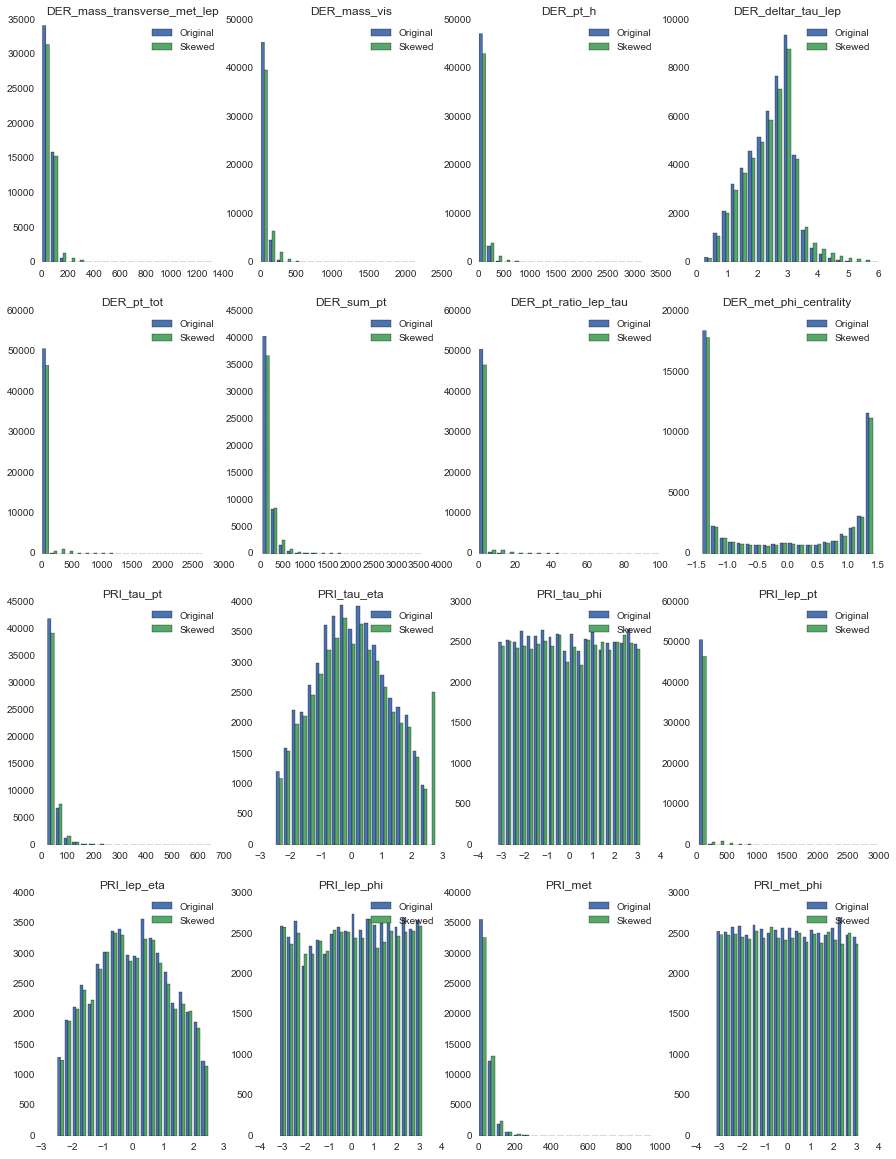

In [10]:
# Choose a feauture to look at :
X_origin = X_df.values[np.where(Y_df==0)[0]]
X_skewed = X_df.values[np.where(Y_df==1)[0]]

n_features = X_df.shape[1]
fig, axes = plt.subplots(int(np.ceil(n_features//4)), 4, figsize=(15,20))
axes = axes.ravel()
for i in range(n_features):
    axes[i].hist([X_origin[:, i], X_skewed[:, i]], bins=20, label=['Original', 'Skewed']);
    axes[i].set_title(X_df.columns[i])
    axes[i].legend(loc=1)


## Prediction model 
We are going to follow the scikit-learn API specs. 
Basically, 
- inherit from `BaseEstimator`,
- initiate all of the arguments and configurations in the `__init__()` function,
- implement a `fit()` and  a `predict()` function.

More information in the [official documentation](http://scikit-learn.org/stable/developers/contributing.html#apis-of-scikit-learn-objects).

## Submission

For your submissions, you have to write 1 classe, saved in 1 file:   
* a class <code>Classification</code> to predict the origin of the example (original or skewed).

When submitting this file (copy-paste on the web interface of the RAMP), they are uploaded to our servers and run to give you a score!  

### Classifier


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.pipeline import make_pipeline

from sklearn.base import BaseEstimator
from sklearn.naive_bayes import GaussianNB

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = RandomForestClassifier()

    def fit(self, X, y):
        return self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)
    
    def predict_proba(self, X):
        return self.clf.predict_proba(X)
    
    


## Unit testing

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Place the python files <code>classifier.py</code> and <code>user_test_submission.py</code></a> in a directory, set the paths to the data files in <code>user_test_submission.py</code>, and run 

<code>python user_test_submission.py</code>

If it runs and prints 
<code>
Reading file ...
Training ...
\-------------------------------------------------------------
accuracy =  [some_number_between_0_and_1]
ROC AUC =  [some_number_between_0_and_1]
\-------------------------------------------------------------
accuracy =  [some_number_between_0_and_1]
ROC AUC =  [some_number_between_0_and_1]
</code>
you can submit the code.

In [12]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_auc_score 


X = X_df
y = Y_df.values.ravel()

skf = StratifiedShuffleSplit(y, n_iter=3, test_size=0.5, random_state=57)
print("Training ...")
for valid_train_is, valid_test_is in skf:
    print('-------------------------------------------------------------')

    X_valid_train = X.ix[valid_train_is] #[X[i] for i in valid_train_is]
    y_valid_train = y[valid_train_is]
    X_valid_test = X.ix[valid_test_is] #[X[i] for i in valid_test_is]
    y_valid_test = y[valid_test_is]
    
    clf = Classifier()
    clf.fit(X_valid_train, y_valid_train)
    y_valid_pred = clf.predict_proba(X_valid_test)
    print('accuracy = ', accuracy_score(y_valid_test, y_valid_pred[:, 1] > 0.5))
    print('ROC AUC = ', roc_auc_score(y_valid_test, y_valid_pred[:, 1]))

Training ...
-------------------------------------------------------------
accuracy =  0.57026
ROC AUC =  0.614804457875
-------------------------------------------------------------
accuracy =  0.57188
ROC AUC =  0.618158100705
-------------------------------------------------------------
accuracy =  0.57198
ROC AUC =  0.616613063996


## Variable importances

This will plot the variable importance according to your model.

**Your model may not implement it, this is an example of how to do it with RandomForest**

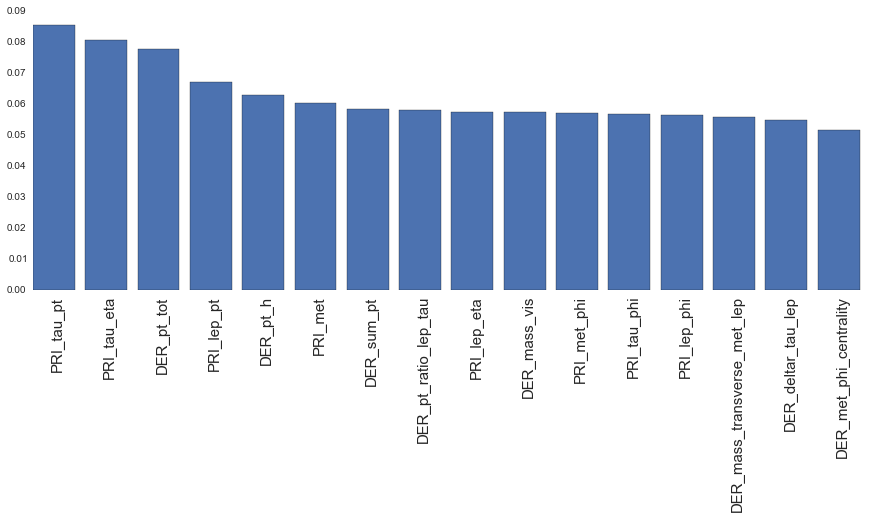

In [13]:
plt.figure(figsize=(15, 5))

ordering = np.argsort(clf.clf.feature_importances_)[::-1][:50]

importances = clf.clf.feature_importances_[ordering]
feature_names = X_df.columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

## Roc curve

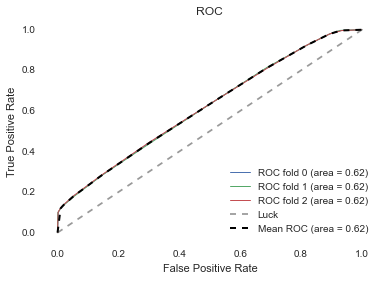

In [14]:
from scipy import interp
from sklearn.metrics import roc_curve , auc
from sklearn.pipeline import make_pipeline

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedShuffleSplit(y, n_iter=3, test_size=0.5, random_state=57)
classifier = Classifier()

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
X = X_df
y = Y_df.values.ravel()

for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(X.ix[train], y[train]).predict_proba(X.ix[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## Learning curves

In [15]:
def plot_learning_score(train_sizes, train_scores, test_scores, score_name='Score'):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title('Learning curve')
    if score_name != "Time":
        plt.ylim(0, 1)
    plt.xlabel("Training examples")
    plt.ylabel(score_name)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training "+score_name)
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation "+score_name)
    plt.legend(loc="best")
    plt.show()

The next cell may take some time.

In [16]:
import time
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score 

sizes = np.linspace(0.1, 1., num=6)
train_accuracy = []
test_accuracy = []
train_auc = []
test_auc = []
train_t = []  # Training time
test_t = []  # Testing time
for size in sizes:
    _train_accuracy = []
    _test_accuracy = []
    _train_auc = []
    _test_auc = []
    _train_t = []  # Training Time
    _test_t = []  # Testing Time
    skf = StratifiedShuffleSplit(y[:int(size*y.shape[0])], n_iter=3, test_size=0.5, random_state=57)
    for valid_train_is, valid_test_is in skf:
        X_valid_train = X.ix[valid_train_is] #[X[i] for i in valid_train_is]
        y_valid_train = y[valid_train_is]
        X_valid_test = X.ix[valid_test_is] #[X[i] for i in valid_test_is]
        y_valid_test = y[valid_test_is]

        clf = Classifier()
        
        start = time.time()
        clf.fit(X_valid_train, y_valid_train)
        _train_t.append(time.time()-start)
        
        start = time.time()
        y_valid_pred = clf.predict(X_valid_train)
        half_time = time.time()-start
        _train_accuracy.append(accuracy_score(y_valid_pred, y_valid_train))
        _train_auc.append(roc_auc_score(y_valid_pred, y_valid_train))
        
        start = time.time()
        y_valid_pred = clf.predict(X_valid_test)
        _test_t.append(time.time()-start+half_time)
        _test_accuracy.append(accuracy_score(y_valid_pred, y_valid_test))
        _test_auc.append(roc_auc_score(y_valid_pred, y_valid_test))
    train_accuracy.append(_train_accuracy)
    test_accuracy.append(_test_accuracy)
    train_auc.append(_train_auc)
    test_auc.append(_test_auc)
    train_t.append(_train_t)
    test_t.append(_test_t)
    
train_accuracy = np.array(train_accuracy)
test_accuracy = np.array(test_accuracy)
train_auc = np.array(train_auc)
test_auc = np.array(test_auc)
train_t = np.array(train_t)
test_t = np.array(test_t)

/Users/kegl/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


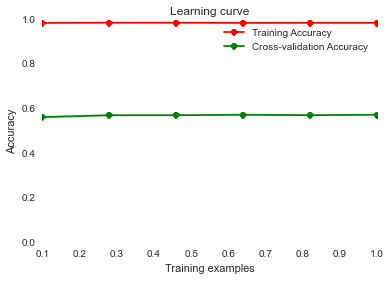

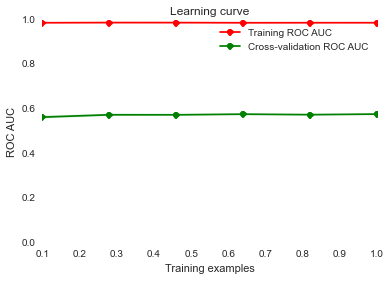

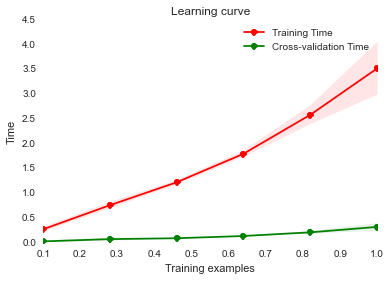

In [17]:
plot_learning_score(sizes, train_accuracy, test_accuracy, score_name='Accuracy')
plot_learning_score(sizes, train_auc, test_auc, score_name='ROC AUC')
plot_learning_score(sizes, train_t, test_t, score_name='Time')
